In [2]:
pip install yfinance

In [22]:
# Grab Data
import yfinance as yf

# Common Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

In [20]:
# Download the data
# The EUR/USD exchange rate data from Yahoo Finance
data = yf.download("EURUSD=X", start="2013-01-01", end="2025-04-15")["Close"]
data.head()

[*********************100%***********************]  1 of 1 completed


Ticker,EURUSD=X
Date,
2013-01-01,1.320132
2013-01-02,1.319784
2013-01-03,1.318218
2013-01-04,1.303271
2013-01-07,1.306745


In [16]:
# Create a DataFrame from the Downloaded Data
raw_data = pd.DataFrame(data).reset_index()
raw_data.rename(columns={ "EURUSD=X": "Close"}, inplace=True)  # Change 'Close' to 'EURUSD=X'

# Calculate the returns and add them to the DataFrame
raw_data["Returns"] = raw_data["Close"].pct_change()

# When the market direction is greater than 0 --> class 1 (up), else class 0 (down)
raw_data["Direction"] = np.where(raw_data["Returns"] > 0, 1, 0)

raw_data.head()

Ticker,Date,Close,Returns,Direction
0,2013-01-01,1.320132,NaN,0
1,2013-01-02,1.319784,-0.000264,0
2,2013-01-03,1.318218,-0.001186,0
3,2013-01-04,1.303271,-0.011338,0
4,2013-01-07,1.306745,0.002666,1


In [21]:
# Last 5 Days of Data to predict the value
lags = 5
# Create lagged features
cols = []
for lag in range(1, lags + 1):
    col = f"lag_{lag}"
    raw_data[col] = raw_data["Returns"].shift(lag)
    cols.append(col)
raw_data.dropna(inplace=True)
raw_data.round(4).tail()

Ticker,Date,Close,Returns,Direction,lag_1,lag_2,lag_3,lag_4,lag_5
3195,2025-04-08,1.0915,-0.0063,0,-0.0054,0.0124,0.0104,-0.0021,-0.0005
3196,2025-04-09,1.0980,0.0060,1,-0.0063,-0.0054,0.0124,0.0104,-0.0021
3197,2025-04-10,1.0952,-0.0026,0,0.0060,-0.0063,-0.0054,0.0124,0.0104
3198,2025-04-11,1.1258,0.0279,1,-0.0026,0.0060,-0.0063,-0.0054,0.0124
3199,2025-04-14,1.1343,0.0076,1,0.0279,-0.0026,0.0060,-0.0063,-0.0054


### Neural Network Code

In [24]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, RMSprop
import random

In [26]:
optimizer = Adam(learning_rate=0.001)  # You can also try RMSprop or SGD
# Define the model
def set_seeds(seed =42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [27]:
set_seeds()
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(lags,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification
model.compile(optimizer=optimizer, 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

c:\Users\santi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
train_set, test_set = np.split(raw_data, [int(0.70 * len(raw_data))])

c:\Users\santi\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [29]:
mu, std = train_set.mean(), train_set.std()

In [30]:
# Normalize the data using the Gaussian distribution
training_set = (train_set - mu) / std
test_data_ = (test_set - mu) / std

C:\Users\santi\AppData\Local\Temp\ipykernel_4488\3016182581.py:2: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  training_set = (train_set - mu) / std
C:\Users\santi\AppData\Local\Temp\ipykernel_4488\3016182581.py:3: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  test_data_ = (test_set - mu) / std


In [31]:
%%time
model.fit(train_set[cols], 
          train_set["Direction"],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False)

CPU times: total: 39.2 s
Wall time: 37.3 s


In [33]:
res = pd.DataFrame(model.history.history)

<Axes: title={'center': 'Accuracy'}>

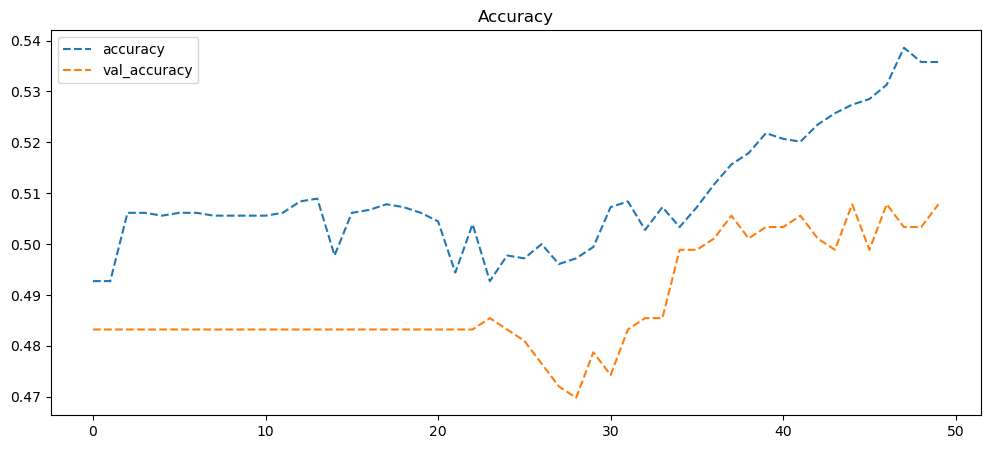

In [34]:
# Accuracy of the Model for Training and Validation Data
res[["accuracy", "val_accuracy"]].plot(title="Accuracy", figsize=(12, 5), style="--")